# **INITIALIZATION**

In [46]:
import pandas as pd
import numpy as nd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tabulate import tabulate
from IPython.display import display, Image
plt.ioff()

sns.set(style="whitegrid", context="paper", rc={"axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 12, "ytick.labelsize": 12})

# URL to get raw CSV data from GitHub
url = "https://raw.githubusercontent.com/ayushinto-space/Performance-Metrics-and-Sales-Analysis-Using-Python/main/Sales_Dataset_Uncleaned.csv"
df_unclean = pd.read_csv(url)
df_unclean.head()

,Order ID,Order Date,Customer Name,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


# **DATA CLEANING**

In [ ]:
df_unclean.columns = df_unclean.columns.str.strip().str.lower().str.replace(" ", "_")
df_unclean.drop_duplicates(inplace=True)

num_cols = ['quantity', 'unit_price', 'discount', 'sales', 'profit']
df_unclean['order_date'] = pd.to_datetime(df_unclean['order_date'], errors='coerce')
df_unclean[num_cols] = df_unclean[num_cols].apply(pd.to_numeric, errors='coerce')

# missing value handles
for col in num_cols:
    df_unclean[col] = df_unclean[col].fillna(df_unclean[col].median())

cat_cols = ['customer_name','region','city','category','sub-category',
            'product_name','payment_mode']
for col in cat_cols:
    df_unclean[col] = df_unclean[col].fillna('Unknown')

# data uniformity
df_unclean['profit_margin'] = (df_unclean['profit'] / df_unclean['sales'])*100
df_unclean['category'] = df_unclean['category'].str.title()
df_unclean['sub-category'] = df_unclean['sub-category'].str.title()
df_unclean['city'] = df_unclean['city'].str.title()
df_unclean['region'] = df_unclean['region'].str.title()
df_unclean['payment_mode'] = df_unclean['payment_mode'].str.title()
df_unclean['order_month_name'] = df_unclean['order_date'].dt.month_name()
df_unclean['order_month_num'] = df_unclean['order_date'].dt.month


# data outliners
q99 = df_unclean['quantity'].quantile(0.99)
df_unclean['quantity'] = df_unclean['quantity'].clip(upper=q99)
p99 = df_unclean['unit_price'].quantile(0.99)
df_unclean['unit_price'] = df_unclean['unit_price'].clip(upper=p99)

# save
df_unclean.to_csv("Sales_Cleaned.csv", index=False)
files.download("Sales_Cleaned.csv")

print(df_unclean.info())
print(df_unclean.isna().sum())
df_unclean.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          5000 non-null   int64         
 1   order_date        5000 non-null   datetime64[ns]
 2   customer_name     5000 non-null   object        
 3   region            5000 non-null   object        
 4   city              5000 non-null   object        
 5   category          5000 non-null   object        
 6   sub-category      5000 non-null   object        
 7   product_name      5000 non-null   object        
 8   quantity          5000 non-null   int64         
 9   unit_price        5000 non-null   float64       
 10  discount          5000 non-null   int64         
 11  sales             5000 non-null   float64       
 12  profit            5000 non-null   float64       
 13  payment_mode      5000 non-null   object        
 14  profit_margin     5000 n

,order_id,order_date,customer_name,region,city,category,sub-category,product_name,quantity,unit_price,discount,sales,profit,payment_mode,profit_margin,order_month_name,order_month_num
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294.0,5,68958.6,10525.09,Debit Card,15.262911,October,10
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165.0,20,33732.0,6299.66,Debit Card,18.675620,August,8
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876.0,20,207603.2,19850.27,Credit Card,9.561640,November,11
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320.0,15,158610.0,36311.02,Upi,22.893273,May,5
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037.0,10,45033.3,9050.04,Debit Card,20.096329,January,1


# **EXPLORATION FUNCTIONS**

## **TIME-BASED FUNCTIONS**

In [ ]:
# sales by year
def sales_by_year(df_clean):
    df_copy = df_clean.copy()
    df_copy["year"] = df_copy["order_date"].dt.year
    return df_copy.groupby("year")["sales"].sum()

# profit margin by year
def profit_margin_by_year(df_clean):
    df_copy = df_clean.copy()
    df_copy["year"] = df_copy["order_date"].dt.year
    yearly = df_copy.groupby("year")[["sales", "profit"]].sum()
    yearly["profit_margin"] = yearly["profit"] / yearly["sales"]
    return yearly["profit_margin"]

# sales by month
def sales_by_month(df_clean):
    df_clean = df_clean.copy()
    df_clean['month'] = df_clean['order_date'].dt.to_period('M')
    monthly = df_clean.groupby('month')['profit'].sum()
    return monthly

## **REGION-BASED FUNCTIONS**

In [ ]:
def top_cities(df):
    df_copy = df.copy()
    city_data = df_copy.groupby('city')[['sales','profit']].sum()
    city_data = city_data.sort_values('sales', ascending=False).head(10)
    return city_data

# **EXPLORATION**

/tmp/ipython-input-1324421134.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_sales.index, y=yearly_sales.values, palette="PuBuGn", hue=None, legend=False)


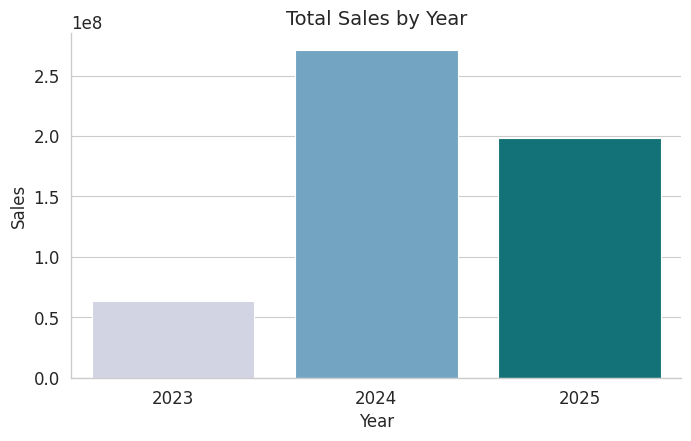

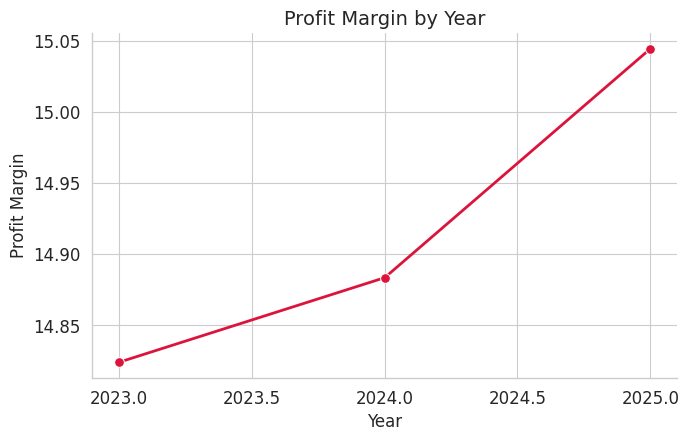

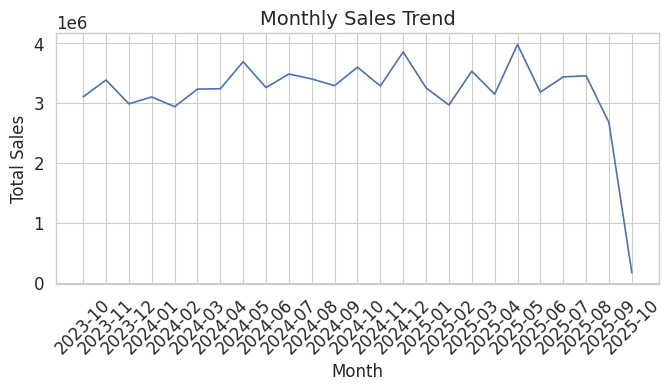

/tmp/ipython-input-1324421134.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_data.index, y=city_data['sales'], palette='coolwarm')


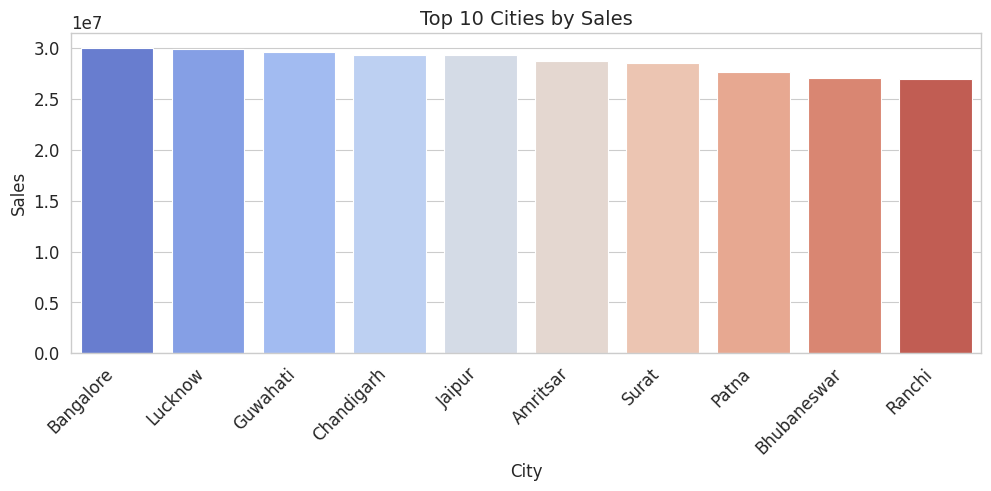

In [60]:
url = "https://raw.githubusercontent.com/ayushinto-space/Performance-Metrics-and-Sales-Analysis-Using-Python/main/Sales_Cleaned.csv"
df_clean = pd.read_csv(url)
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])

df_clean.head()

# plot sales by year
def plot_sales_by_year(df_clean):
    yearly_sales = sales_by_year(df_clean)

    plt.figure(figsize=(7, 4.5))
    sns.barplot(x=yearly_sales.index, y=yearly_sales.values, palette="PuBuGn", hue=None, legend=False)

    plt.title("Total Sales by Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Sales", fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    sns.despine()
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

#plot profit margin by year
def plot_profit_margin_by_year(df_clean):
    yearly_margin = profit_margin_by_year(df_clean)
    plt.figure(figsize=(7, 4.5))
    sns.lineplot(x=yearly_margin.index, y=yearly_margin.values*100, marker='o', linewidth=2,
        markersize=7, color="crimson")

    plt.title("Profit Margin by Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Profit Margin", fontsize=12)

    plt.xticks([2023, 2023.5, 2024, 2024.5, 2025])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    sns.despine()
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

def plot_sales_by_month(df_clean):
    monthly = sales_by_month(df_clean)
    plt.figure(figsize=(7,4))
    plt.plot(monthly.index.astype(str), monthly.values)
    plt.xticks(rotation=45)
    plt.title("Monthly Sales Trend")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

def plot_top_cities(df):
    city_data = top_cities(df)
    plt.figure(figsize=(10,5))
    sns.barplot(x=city_data.index, y=city_data['sales'], palette='coolwarm')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 10 Cities by Sales")
    plt.xlabel("City")
    plt.ylabel("Sales")
    plt.tight_layout()
    fig = plt.gcf()
    plt.show()
    plt.close(fig)

# calling all plot functions
plot_sales_by_year(df_clean,)
plot_profit_margin_by_year(df_clean)
plot_sales_by_month(df_clean)
plot_top_cities(df_clean)

# **INTERACTIVE ENVIRONMENT**

Dataset loaded successfully. Total rows: 5000

------------ MENU ------------
1. Add new record
2. Modify a record by Order ID
3. Delete a record by Order ID
4. Show dataset preview
5. Satistics 
6. Exit

Enter choice: 5

---- Statistical Analysis ----
1. Sales by Year
2. Profit Margin by Year
3. Sales by Month
4. Top City Sales
5. Exit

Enter choice: 2


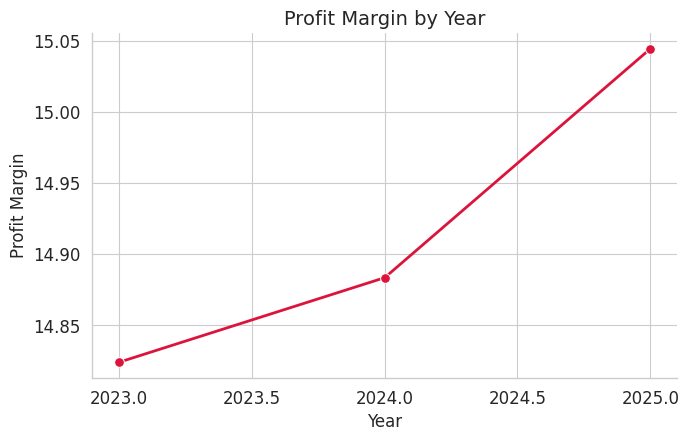


------------ MENU ------------
1. Add new record
2. Modify a record by Order ID
3. Delete a record by Order ID
4. Show dataset preview
5. Satistics 
6. Exit


KeyboardInterrupt: Interrupted by user

In [61]:
def calculate_sales(unit_price, quantity, discount):
    return unit_price * quantity * (1 - discount)

def calculate_profit(sales):
    return sales * 0.15  # % share of sales used as COGS price is not available

def calculate_profit_margin(sales, profit):
    return (profit / sales) * 100 if sales != 0 else 0

def update_month_columns(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['order_month_name'] = df['order_date'].dt.month_name()
    df['order_month_num'] = df['order_date'].dt.month
    return df

def save_csv(df):
    df.to_csv("updated_sales_data.csv", index=False)
    print("\nSaved as updated_sales_data.csv\n")

# menu functions
def add_new_record(df_edit):
    print("\nEnter New Record Details:")
    new_row = {}
    new_row['order_id'] = input("Order ID: ")
    new_row['order_date'] = input("Order Date (YYYY-MM-DD): ")
    new_row['customer_name'] = input("Customer Name: ")
    new_row['region'] = input("Region: ")
    new_row['city'] = input("City: ")
    new_row['category'] = input("Category: ")
    new_row['subcategory'] = input("Subcategory: ")
    new_row['product_name'] = input("Product Name: ")
    new_row['quantity'] = int(input("Quantity: "))
    new_row['unit_price'] = float(input("Unit Price: "))
    new_row['discount'] = float(input("Discount (0-1): "))

    new_row['sales'] = calculate_sales(new_row['unit_price'], new_row['quantity'], new_row['discount'])
    new_row['profit'] = calculate_profit(new_row['sales'])
    new_row['payment_mode'] = input("Payment Mode: ")
    new_row['profit_margin'] = calculate_profit_margin(new_row['sales'], new_row['profit'])

    df_edit.loc[len(df_edit)] = new_row
    df_edit = update_month_columns(df_edit)
    save_csv(df_edit)

    print("\nRecord Added Successfully! New rows:\n")
    print(tabulate(df_edit.tail(5), headers="keys", tablefmt="psql"))
    return df_edit

def modify_record(df_edit):
    order_id = input("\nEnter Order ID to modify: ")
    if order_id not in df_edit['order_id'].values:
        print("Order ID not found!\n")
        return df_edit

    row_index = df_edit[df_edit['order_id'] == order_id].index[0]

    print("\nColumns you can modify:")
    print(df_edit.columns.tolist())
    col = input("Column name to modify: ")

    if col not in df_edit.columns:
        print("Invalid column!\n")
        return df_edit

    new_value = input("Enter new value: ")

    # Convert numeric fields
    if col in ['quantity', 'order_month_num']:
        new_value = int(new_value)
    elif col in ['unit_price', 'discount', 'sales', 'profit', 'profit_margin']:
        new_value = float(new_value)

    df_edit.at[row_index, col] = new_value

    # Recalculate dependent fields if needed
    if col in ['order_date', 'quantity', 'unit_price', 'discount', 'profit']:
        r = df_edit.loc[row_index]
        df_edit.at[row_index, 'sales'] = calculate_sales(r['unit_price'], r['quantity'], r['discount'])
        df_edit.at[row_index, 'profit_margin'] = calculate_profit_margin(df_edit.at[row_index, 'sales'], r['profit'])
        df_edit = update_month_columns(df_edit)

    save_csv(df_edit)
    print("\nRecord Modified! Updated row:\n")
    print(tabulate(df_edit.loc[[row_index]], headers="keys", tablefmt="psql"))
    return df_edit

def delete_record(df_edit):
    order_id = input("\nEnter Order ID to delete: ")
    if order_id not in df_edit['order_id'].values:
        print("Order ID not found!\n")
        return df_edit

    df_edit = df_edit[df_edit['order_id'] != order_id].reset_index(drop=True)
    save_csv(df_edit)
    print("\nRecord Deleted! Latest rows:\n")
    print(tabulate(df_edit.tail(5), headers="keys", tablefmt="psql"))
    return df_edit

def statisics_record(df_edit):
    print("\n---- Statistical Analysis ----")
    print("1. Sales by Year")
    print("2. Profit Margin by Year")
    print("3. Sales by Month")
    print("4. Top City Sales")
    print("5. Exit")
    choice = input("\nEnter choice: ")

    if choice == "1":
        plot_sales_by_year(df_edit)
        return df_edit
    elif choice == "2":
        plot_profit_margin_by_year(df_edit)
        return df_edit
    elif choice == "3":
        plot_sales_by_month(df_edit)
        return df_edit
    elif choice == "4":
        plot_top_cities(df_edit)
        return df_edit
    elif choice == "5":
        print("\nExiting statistical analysis...")
        return df_edit
    else:
        print("Invalid choice. Try again.")
        return df_edit

def show_dataset(df_edit):
    print("\n---- Edited Dataset Preview ----")
    print(tabulate(df_edit.head(10), headers="keys", tablefmt="psql"))

# menu editor
def menu_based_data_editor(df_clean):
    df_edit = df_clean.copy()  # work on copy

    while True:
        print("\n------------ MENU ------------")
        print("1. Add new record")
        print("2. Modify a record by Order ID")
        print("3. Delete a record by Order ID")
        print("4. Show dataset preview")
        print("5. Satistics ")
        print("6. Exit")
        choice = input("\nEnter choice: ")

        match choice:
            case "1":
                df_edit = add_new_record(df_edit)
            case "2":
                df_edit = modify_record(df_edit)
            case "3":
                df_edit = delete_record(df_edit)
            case "4":
                show_dataset(df_edit)
            case "5":
                df_edit = statisics_record(df_edit)
                pass
            case "6":
                print("\nExiting menu...")
                return df_edit
            case _:
                print("Invalid choice. Try again.")

# menu viewer
if __name__ == "__main__":
    try:
        print("Dataset loaded successfully. Total rows:", len(df_clean))
    except FileNotFoundError:
        print("File not found! Please make sure 'sales_data.csv' exists.")
        exit()

    df_updated = menu_based_data_editor(df_clean)

    print("\nFinal Edited Dataset Preview:\n")
    print(tabulate(df_updated.tail(10), headers="keys", tablefmt="psql"))
